=== Liposome Hole Analysis Started ===
Found 6664 lipid headgroups
Lipid types: {'DOPE'}
Liposome center: [283.0214  292.8623  169.60266]
Radius stats: avg=152.16Å, max=247.49Å, min=59.85Å, std=36.11Å
Hole detection - Method: std, Threshold: -196.0038
Detected 0 hole bins
No holes found
No hole found, skipping nearby lipid analysis
Figure saved to: largest_hole_analysis.png


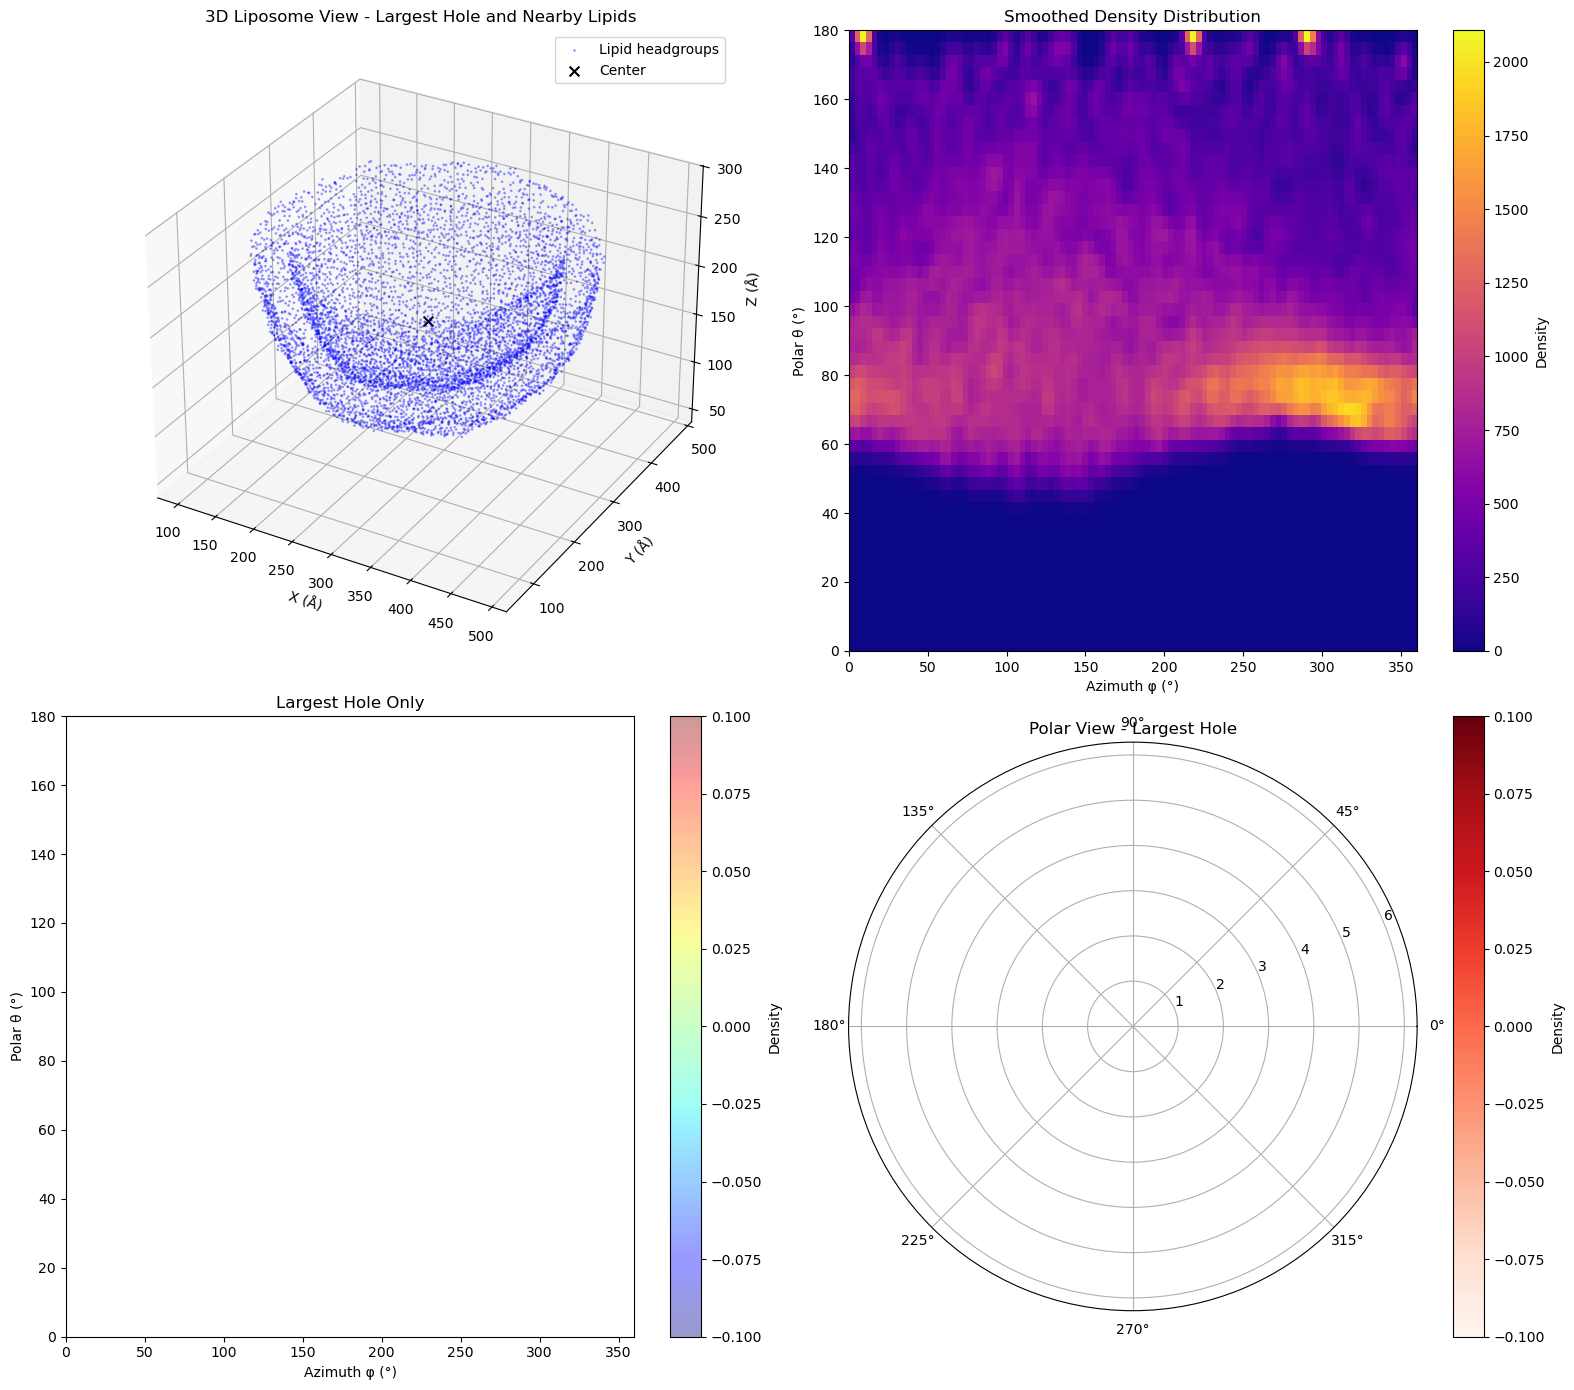


Liposome Hole Analysis Results - Largest Hole Only
Liposome size: 6664 lipids
Average radius: 152.16 Å
Grid resolution: 50 × 100

Largest Hole Analysis:
No holes detected

Note: Only the largest hole is shown. Other smaller holes are ignored.

Analysis completed! Only the largest hole is shown.
Found 0 lipid residues near the hole.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from scipy.spatial import KDTree
from scipy.ndimage import gaussian_filter
from collections import deque
import warnings
warnings.filterwarnings('ignore')

def extract_headgroups(gro_file, lipid_selection="name P"):
    """Extract lipid headgroup coordinates and residue data"""
    u = mda.Universe(gro_file)
    headgroup_atoms = u.select_atoms(lipid_selection)
    coordinates = headgroup_atoms.positions
    n_lipids = len(headgroup_atoms)
    lipid_names = headgroup_atoms.names
    residue_ids = headgroup_atoms.resids
    residue_names = headgroup_atoms.resnames

    print(f"Found {n_lipids} lipid headgroups")
    print(f"Lipid types: {set(residue_names)}")

    return coordinates, n_lipids, lipid_names, residue_ids, residue_names, headgroup_atoms

def calculate_geometry(coordinates):
    """Calculate liposome geometry"""
    center = np.mean(coordinates, axis=0)
    distances = np.linalg.norm(coordinates - center, axis=1)

    avg_radius = np.mean(distances)
    max_radius = np.max(distances)
    min_radius = np.min(distances)
    std_radius = np.std(distances)

    print(f"Liposome center: {center}")
    print(f"Radius stats: avg={avg_radius:.2f}Å, max={max_radius:.2f}Å, "
          f"min={min_radius:.2f}Å, std={std_radius:.2f}Å")

    return center, avg_radius, max_radius, min_radius, std_radius

def create_spherical_grid(n_theta=50, n_phi=100):
    """Create spherical grid"""
    theta_bins = np.linspace(0, np.pi, n_theta + 1)
    phi_bins = np.linspace(0, 2 * np.pi, n_phi + 1)

    theta_centers = (theta_bins[:-1] + theta_bins[1:]) / 2
    phi_centers = (phi_bins[:-1] + phi_bins[1:]) / 2

    d_theta = np.pi / n_theta
    d_phi = 2 * np.pi / n_phi
    bin_areas = np.sin(theta_centers) * d_theta * d_phi

    return theta_bins, phi_bins, theta_centers, phi_centers, bin_areas, n_theta, n_phi

def assign_points_to_bins(coordinates, center, theta_bins, phi_bins, theta_centers, bin_areas, n_theta, n_phi):
    """Assign points to spherical grid bins"""
    relative_coords = coordinates - center
    r = np.linalg.norm(relative_coords, axis=1)

    x, y, z = relative_coords[:, 0], relative_coords[:, 1], relative_coords[:, 2]
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    phi = np.where(phi < 0, phi + 2*np.pi, phi)

    theta_indices = np.digitize(theta, theta_bins) - 1
    phi_indices = np.digitize(phi, phi_bins) - 1

    theta_indices = np.clip(theta_indices, 0, n_theta - 1)
    phi_indices = np.clip(phi_indices, 0, n_phi - 1)

    density_matrix = np.zeros((n_theta, n_phi))

    for i, (t_idx, p_idx) in enumerate(zip(theta_indices, phi_indices)):
        density_matrix[t_idx, p_idx] += 1

    density_per_sr = np.zeros_like(density_matrix)
    for i in range(n_theta):
        if bin_areas[i] > 0:
            density_per_sr[i, :] = density_matrix[i, :] / bin_areas[i]

    return density_matrix, density_per_sr, theta_indices, phi_indices, theta, phi

def smooth_density(density_per_sr, sigma=0.1):
    """Smooth density distribution"""
    smoothed_density = gaussian_filter(density_per_sr, sigma=sigma)
    return smoothed_density

def detect_holes(density_matrix, method='percentile', threshold_value=10):
    """Detect hole regions"""
    flat_density = density_matrix.flatten()

    if method == 'percentile':
        threshold = np.percentile(flat_density[flat_density > 0], threshold_value)
    elif method == 'std':
        mean_density = np.mean(flat_density[flat_density > 0])
        std_density = np.std(flat_density[flat_density > 0])
        threshold = mean_density - threshold_value * std_density
    elif method == 'absolute':
        threshold = threshold_value
    else:
        raise ValueError("Method must be 'percentile', 'std', or 'absolute'")

    holes_mask = density_matrix < threshold
    n_hole_bins = np.sum(holes_mask)

    print(f"Hole detection - Method: {method}, Threshold: {threshold:.4f}")
    print(f"Detected {n_hole_bins} hole bins")

    return holes_mask, threshold

def find_contiguous_holes(holes_mask, n_theta, n_phi):
    """Find contiguous hole regions and keep only the largest one"""
    visited = np.zeros_like(holes_mask, dtype=bool)
    holes = []

    def bfs(start_i, start_j):
        """Breadth-first search for contiguous regions"""
        queue = deque([(start_i, start_j)])
        current_hole = []

        while queue:
            i, j = queue.popleft()
            if visited[i, j]:
                continue

            visited[i, j] = True
            current_hole.append((i, j))

            # Check 4-neighborhood
            for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                ni, nj = i + di, j + dj
                if (0 <= ni < n_theta and 0 <= nj < n_phi and
                    holes_mask[ni, nj] and not visited[ni, nj]):
                    queue.append((ni, nj))

        return current_hole

    for i in range(n_theta):
        for j in range(n_phi):
            if holes_mask[i, j] and not visited[i, j]:
                hole = bfs(i, j)
                if len(hole) > 1:  # Only consider holes with multiple bins
                    holes.append(hole)

    # Find the largest hole
    if holes:
        largest_hole = max(holes, key=len)
        print(f"Found {len(holes)} holes, keeping the largest one with {len(largest_hole)} bins")

        # Create mask with only the largest hole
        largest_hole_mask = np.zeros_like(holes_mask, dtype=bool)
        for i, j in largest_hole:
            largest_hole_mask[i, j] = True

        contiguous_holes = [largest_hole]  # Keep only the largest hole
        holes_mask = largest_hole_mask  # Update holes mask to only include largest hole
    else:
        contiguous_holes = []
        print("No holes found")

    return contiguous_holes, holes_mask

def calculate_hole_statistics(contiguous_holes, bin_areas, avg_radius):
    """Calculate hole statistics for the largest hole only"""
    holes = contiguous_holes
    hole_areas = []

    for hole in holes:
        hole_area = 0.0  # 确保是标量
        for i, j in hole:
            # 确保 bin_areas[i] 是标量
            area_contribution = float(bin_areas[i]) * (float(avg_radius)**2)
            hole_area += area_contribution

        hole_areas.append(float(hole_area))  # 确保添加的是标量

    # 其余代码保持不变...

    if hole_areas:
        total_hole_area = np.sum(hole_areas)
        avg_hole_area = np.mean(hole_areas)
        max_hole_area = np.max(hole_areas)
        n_holes = len(holes)
    else:
        total_hole_area = avg_hole_area = max_hole_area = 0
        n_holes = 0

    sphere_area = 4 * np.pi * avg_radius**2
    hole_coverage = total_hole_area / sphere_area * 100

    hole_stats = {
        'n_holes': n_holes,
        'hole_areas': hole_areas,
        'avg_hole_area': avg_hole_area,
        'max_hole_area': max_hole_area,
        'total_hole_area': total_hole_area,
        'hole_coverage': hole_coverage,
        'sphere_area': sphere_area
    }

    return hole_stats

def find_lipids_near_hole(coordinates, residue_ids, residue_names, center, avg_radius,
                         hole_bins, theta_centers, phi_centers, distance_threshold=10.0):
    """
    Find lipids near the hole region

    Parameters:
    coordinates: all lipid coordinates
    residue_ids: residue IDs for each lipid
    residue_names: residue names for each lipid
    center: liposome center
    avg_radius: average liposome radius
    hole_bins: list of (theta_idx, phi_idx) for hole bins
    theta_centers: theta center values
    phi_centers: phi center values
    distance_threshold: distance threshold for considering lipids as "near" the hole (Å)
    """
    if not hole_bins:
        return [], []

    # Create representative points for the hole region
    hole_points = []
    for theta_idx, phi_idx in hole_bins:
        theta = theta_centers[theta_idx]
        phi = phi_centers[phi_idx]

        # Convert spherical coordinates to Cartesian
        x = center[0] + avg_radius * np.sin(theta) * np.cos(phi)
        y = center[1] + avg_radius * np.sin(theta) * np.sin(phi)
        z = center[2] + avg_radius * np.cos(theta)
        hole_points.append([x, y, z])

    hole_points = np.array(hole_points)

    # Create KDTree for efficient distance calculation
    hole_tree = KDTree(hole_points)

    # Find lipids near any hole point
    nearby_indices = []
    nearby_residues = []

    for i, lipid_coord in enumerate(coordinates):
        # Calculate distance to nearest hole point
        dist, _ = hole_tree.query(lipid_coord.reshape(1, -1))
        if dist[0] <= distance_threshold:
            nearby_indices.append(i)
            nearby_residues.append({
                'residue_id': residue_ids[i],
                'residue_name': residue_names[i],
                'distance_to_hole': dist[0],
                'coordinates': lipid_coord
            })

    # Remove duplicates (same residue ID)
    unique_residues = {}
    for residue in nearby_residues:
        resid = residue['residue_id']
        if resid not in unique_residues or residue['distance_to_hole'] < unique_residues[resid]['distance_to_hole']:
            unique_residues[resid] = residue

    # Sort by residue ID
    sorted_residues = sorted(unique_residues.values(), key=lambda x: x['residue_id'])

    print(f"\nFound {len(sorted_residues)} unique lipid residues near the hole (distance threshold: {distance_threshold}Å)")

    return sorted_residues, nearby_indices

def visualize_results(results, theta_centers, phi_centers, avg_radius, nearby_residues=None, save_path=None):
    """Visualize analysis results - showing only the largest hole"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))

    # 1. 3D liposome view with largest hole and nearby lipids
    ax = axes[0, 0]
    ax.remove()
    ax = fig.add_subplot(2, 2, 1, projection='3d')

    coords = results['coordinates']
    center = results['center']

    # Plot all lipid headgroups
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
              c='blue', alpha=0.3, s=1, label='Lipid headgroups')

    # Plot the largest hole region
    if results['contiguous_holes']:
        largest_hole = results['contiguous_holes'][0]
        hole_coords = []

        for i, j in largest_hole:
            theta = theta_centers[i]
            phi = phi_centers[j]
            x = center[0] + avg_radius * np.sin(theta) * np.cos(phi)
            y = center[1] + avg_radius * np.sin(theta) * np.sin(phi)
            z = center[2] + avg_radius * np.cos(theta)
            hole_coords.append([x, y, z])

        if hole_coords:
            hole_coords = np.array(hole_coords)
            ax.scatter(hole_coords[:, 0], hole_coords[:, 1], hole_coords[:, 2],
                      c='red', s=30, label='Largest hole region')

    # Plot nearby lipids if available
    if nearby_residues:
        nearby_coords = np.array([res['coordinates'] for res in nearby_residues])
        ax.scatter(nearby_coords[:, 0], nearby_coords[:, 1], nearby_coords[:, 2],
                  c='green', s=50, marker='*', label='Lipids near hole')

    ax.scatter(*center, c='black', s=50, marker='x', label='Center')
    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    ax.set_title('3D Liposome View - Largest Hole and Nearby Lipids')
    ax.legend()

    # 2. Smoothed density distribution
    im1 = axes[0, 1].imshow(results['smoothed_density'],
                           extent=[0, 360, 0, 180], aspect='auto',
                           cmap='plasma', origin='lower')
    axes[0, 1].set_xlabel('Azimuth φ (°)')
    axes[0, 1].set_ylabel('Polar θ (°)')
    axes[0, 1].set_title('Smoothed Density Distribution')
    plt.colorbar(im1, ax=axes[0, 1], label='Density')

    # 3. Largest hole only
    hole_density = results['smoothed_density'].copy()
    hole_density[~results['holes_mask']] = np.nan

    im2 = axes[1, 0].imshow(hole_density,
                           extent=[0, 360, 0, 180], aspect='auto',
                           cmap='jet',alpha=0.4, origin='lower')
    axes[1, 0].set_xlabel('Azimuth φ (°)')
    axes[1, 0].set_ylabel('Polar θ (°)')
    axes[1, 0].set_title('Largest Hole Only')
    plt.colorbar(im2, ax=axes[1, 0], label='Density')

    # 4. Polar view of largest hole
    ax_polar = axes[1, 1]
    ax_polar.remove()
    ax_polar = fig.add_subplot(2, 2, 4, projection='polar')

    # Create polar density plot highlighting only the largest hole
    theta_grid, phi_grid = np.meshgrid(phi_centers, theta_centers)
    density_polar = results['smoothed_density'].copy()
    density_polar[~results['holes_mask']] = np.nan

    im3 = ax_polar.pcolormesh(phi_grid, theta_grid, density_polar, cmap='Reds', shading='auto')
    ax_polar.set_title('Polar View - Largest Hole')
    plt.colorbar(im3, ax=ax_polar, label='Density')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")

    plt.show()

def print_results(results, n_theta, n_phi, nearby_residues=None):
    """Print analysis results for the largest hole only"""
    stats = results['hole_stats']

    print("\n" + "="*60)
    print("Liposome Hole Analysis Results - Largest Hole Only")
    print("="*60)
    print(f"Liposome size: {results['n_lipids']} lipids")
    print(f"Average radius: {results['radii']['avg']:.2f} Å")
    print(f"Grid resolution: {n_theta} × {n_phi}")

    print(f"\nLargest Hole Analysis:")
    if stats['n_holes'] > 0:
        print(f"Hole area: {stats['max_hole_area']:.2f} Å²")
        print(f"Number of grid bins in hole: {len(results['contiguous_holes'][0])}")
        print(f"Hole coverage: {stats['hole_coverage']:.2f}% of surface area")
        print(f"Total surface area: {stats['sphere_area']:.2f} Å²")

        # Calculate approximate hole diameter (assuming circular hole)
        hole_radius = np.sqrt(stats['max_hole_area'] / np.pi)
        print(f"Approximate hole diameter: {2 * hole_radius:.2f} Å")
    else:
        print("No holes detected")

    # Print nearby lipid information
    if nearby_residues:
        print(f"\nLipids near the hole region:")
        print("-" * 40)
        for residue in nearby_residues[:20]:  # Show first 20 residues
            print(f"ResID: {residue['residue_id']:4d} | "
                  f"Name: {residue['residue_name']:6s} | "
                  f"Distance: {residue['distance_to_hole']:6.2f} Å")

        if len(nearby_residues) > 20:
            print(f"... and {len(nearby_residues) - 20} more residues")

    print(f"\nNote: Only the largest hole is shown. Other smaller holes are ignored.")

def analyze_liposome_holes(gro_file, lipid_selection="name PO4 ROH", n_theta=50, n_phi=100,
                          hole_distance_threshold=10.0):
    """Perform complete liposome hole analysis - function version"""
    print("=== Liposome Hole Analysis Started ===")

    # 1. Extract headgroups (now with residue information)
    coordinates, n_lipids, lipid_names, residue_ids, residue_names, headgroup_atoms = extract_headgroups(
        gro_file, lipid_selection)

    # 2. Calculate geometry
    center, avg_radius, max_radius, min_radius, std_radius = calculate_geometry(coordinates)

    # 3. Create spherical grid
    theta_bins, phi_bins, theta_centers, phi_centers, bin_areas, n_theta, n_phi = create_spherical_grid(n_theta, n_phi)

    # 4. Assign points to bins and calculate density
    density_matrix, density_per_sr, theta_idx, phi_idx, theta, phi = assign_points_to_bins(
        coordinates, center, theta_bins, phi_bins, theta_centers, bin_areas, n_theta, n_phi)

    # 5. Smooth density
    smoothed_density = smooth_density(density_per_sr, sigma=1.0)

    # 6. Detect holes
    holes_mask, threshold = detect_holes(smoothed_density, method='std', threshold_value=2)

    # 7. Find contiguous holes and keep only the largest one
    contiguous_holes, holes_mask = find_contiguous_holes(holes_mask, n_theta, n_phi)

    # 8. Calculate statistics
    hole_stats = calculate_hole_statistics(contiguous_holes, bin_areas, avg_radius)

    # 9. Find lipids near the hole
    nearby_residues = []
    if contiguous_holes:
        nearby_residues, nearby_indices = find_lipids_near_hole(
            coordinates, residue_ids, residue_names, center, avg_radius,
            contiguous_holes[0], theta_centers, phi_centers, hole_distance_threshold)
    else:
        print("No hole found, skipping nearby lipid analysis")

    # Compile results
    results = {
        'coordinates': coordinates,
        'center': center,
        'radii': {'avg': avg_radius, 'max': max_radius, 'min': min_radius, 'std': std_radius},
        'density_matrix': density_matrix,
        'smoothed_density': smoothed_density,
        'holes_mask': holes_mask,
        'contiguous_holes': contiguous_holes,
        'hole_stats': hole_stats,
        'n_lipids': n_lipids,
        'nearby_residues': nearby_residues,
        'residue_ids': residue_ids,
        'residue_names': residue_names
    }

    return results, theta_centers, phi_centers, avg_radius, n_theta, n_phi, nearby_residues

def analyze_largest_hole_only(gro_file, lipid_selection="name PO4 ROH", hole_distance_threshold=10.0):
    """Analyze only the largest hole in the liposome - main function"""
    results, theta_centers, phi_centers, avg_radius, n_theta, n_phi, nearby_residues = analyze_liposome_holes(
        gro_file, lipid_selection, hole_distance_threshold=hole_distance_threshold)

    visualize_results(results, theta_centers, phi_centers, avg_radius, nearby_residues,
                     save_path="largest_hole_analysis.png")
    print_results(results, n_theta, n_phi, nearby_residues)

    return results, nearby_residues


if __name__ == "__main__":
    gro_file_path = "60ns.gro"  # Replace with actual file path

    results, nearby_residues = analyze_largest_hole_only(gro_file_path, hole_distance_threshold=20.0)


    print("\nAnalysis completed! Only the largest hole is shown.")
    print(f"Found {len(nearby_residues)} lipid residues near the hole.")


In [2]:
if __name__ == "__main__":
    gro_file_path = "60.gro"  # Replace with actual file path

    results, nearby_residues = analyze_largest_hole_only(gro_file_path, hole_distance_threshold=20.0)


    print("\nAnalysis completed! Only the largest hole is shown.")
    print(f"Found {len(nearby_residues)} lipid residues near the hole.")

NameError: name 'analyze_largest_hole_only' is not defined

Single frame analysis (OUTER LAYER ONLY):
LIPOSOME PORE ANALYSIS - MULTI-SCALE APPROACH
ANALYZING OUTER LAYER LIPIDS ONLY
Loaded 6664 lipid headgroups
Lipid types: {'DOPE'}
Center: [283.0214  292.8623  169.60266]
Average radius: 152.16 Å

[1.5] Identifying outer layer lipids...
  System shape: plane
  Identified 3326 upper lipids and 3338 lower lipids
  Z threshold: 171.90 Å (median Z)
  Filtering to analyze ONLY outer layer lipids...

[1] Global Shape Analysis:
  Shape type: plane
  Flatness: 0.950
  Aspect ratio: 19.956
  Eigenvalues ratio: [0.5169047  0.45719296 0.02590235]

[2] Multi-scale pore detection...
  Detected shape: plane (flatness: 0.950)
  Processing scale 1/5: 5.0 Å
  Processing scale 2/5: 8.8 Å
  Processing scale 3/5: 12.5 Å
  Processing scale 4/5: 16.2 Å
  Processing scale 5/5: 20.0 Å
  Computing normals and curvatures...
  Using weights: density=0.20, normal=0.70, curvature=0.10
  Pore detection threshold: 0.196
  Potential pore points: 499/3326
  Shape-adaptive weig

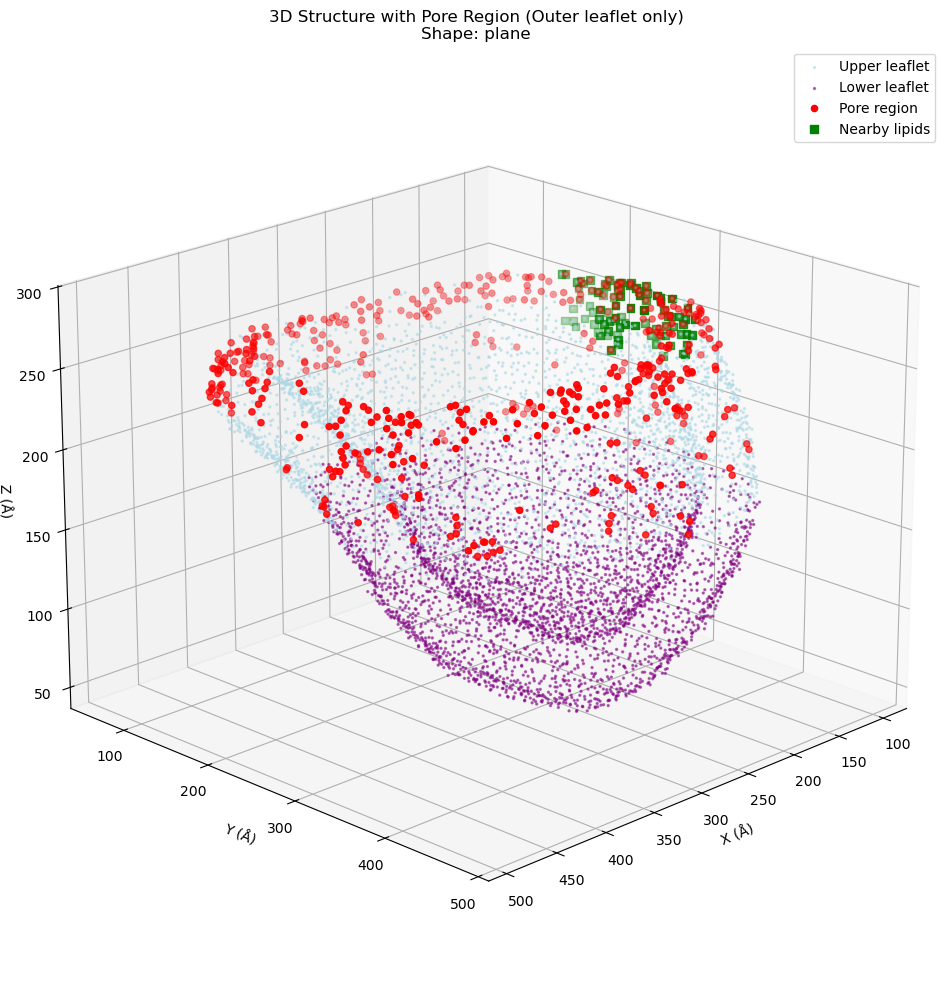

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from scipy.spatial import KDTree, ConvexHull
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

class LiposomePoreAnalyzer:
    """
    综合脂质体孔洞分析器，可处理从平面到完整球体的所有状态
    修改版：仅保留3D可视化，添加周长计算，并支持仅分析外层脂质
    """

    def __init__(self, gro_file, lipid_selection="name PO4", analyze_outer_layer_only=False):
        """初始化分析器"""
        self.gro_file = gro_file
        self.lipid_selection = lipid_selection
        self.analyze_outer_layer_only = analyze_outer_layer_only
        self.coordinates = None
        self.residue_ids = None
        self.residue_names = None
        self.center = None
        self.avg_radius = None
        self.outer_layer_mask = None
        self.original_coordinates = None  # 保存原始坐标用于可视化
        self.original_residue_ids = None
        self.original_residue_names = None

    def load_structure(self):
        """加载结构数据"""
        u = mda.Universe(self.gro_file)
        headgroup_atoms = u.select_atoms(self.lipid_selection)

        # 保存原始数据（用于可视化）
        self.original_coordinates = headgroup_atoms.positions.copy()
        self.original_residue_ids = headgroup_atoms.resids.copy()
        self.original_residue_names = headgroup_atoms.resnames.copy()

        # 计算中心
        self.center = np.mean(headgroup_atoms.positions, axis=0)
        distances = np.linalg.norm(headgroup_atoms.positions - self.center, axis=1)
        self.avg_radius = np.mean(distances)

        # 初始设置为使用所有脂质
        self.coordinates = headgroup_atoms.positions.copy()
        self.residue_ids = headgroup_atoms.resids.copy()
        self.residue_names = headgroup_atoms.resnames.copy()

        print(f"Loaded {len(self.coordinates)} lipid headgroups")
        print(f"Lipid types: {set(self.residue_names)}")
        print(f"Center: {self.center}")
        print(f"Average radius: {self.avg_radius:.2f} Å")

        return self

    def identify_outer_layer(self):
        """
        识别外层脂质
        根据系统形状采用不同策略
        """
        if self.coordinates is None or self.center is None:
            self.load_structure()

        # 保存原始数据
        all_coords = self.original_coordinates
        all_resids = self.original_residue_ids
        all_resnames = self.original_residue_names

        # 重新加载完整数据（确保使用原始数据）
        self.coordinates = all_coords.copy()
        self.residue_ids = all_resids.copy()
        self.residue_names = all_resnames.copy()

        # 估计全局形状
        shape_info = self.estimate_global_shape()
        shape_type = shape_info['shape_type']

        print(f"\n[1.5] Identifying outer layer lipids...")
        print(f"  System shape: {shape_type}")

        # 根据形状选择策略
        if shape_type == "sphere":
            # 球形：基于到中心的距离
            distances = np.linalg.norm(self.coordinates - self.center, axis=1)
            # 使用中位数作为分界点（更稳健）
            radius_median = np.median(distances)

            # 外层：距离 > 中位数
            self.outer_layer_mask = distances > radius_median

            # 计算内外层比例
            outer_count = np.sum(self.outer_layer_mask)
            inner_count = len(distances) - outer_count
            print(f"  Identified {outer_count} outer lipids and {inner_count} inner lipids")
            print(f"  Radius threshold: {radius_median:.2f} Å (median distance)")

        elif shape_type == "plane":
            # 平面：基于Z坐标（假设膜在XY平面）
            z_coords = self.coordinates[:, 2]
            z_median = np.median(z_coords)

            # 外层（上层）：Z > 中位数
            self.outer_layer_mask = z_coords > z_median

            # 计算内外层比例
            outer_count = np.sum(self.outer_layer_mask)
            inner_count = len(z_coords) - outer_count
            print(f"  Identified {outer_count} upper lipids and {inner_count} lower lipids")
            print(f"  Z threshold: {z_median:.2f} Å (median Z)")

        else:  # transition
            # 过渡态：使用PCA确定主平面
            pca = PCA(n_components=3)
            pca.fit(self.coordinates)

            # 获取主轴（第一主成分是主要延伸方向）
            main_axis = pca.components_[0]

            # 计算点在主轴上的投影
            projections = np.dot(self.coordinates - self.center, main_axis)

            # 使用中位数作为分界
            proj_median = np.median(projections)

            # 外层：投影 > 中位数
            self.outer_layer_mask = projections > proj_median

            # 计算内外层比例
            outer_count = np.sum(self.outer_layer_mask)
            inner_count = len(projections) - outer_count
            print(f"  Identified {outer_count} outer lipids and {inner_count} inner lipids")
            print(f"  Projection threshold: {proj_median:.2f} (median projection)")

        # 如果要求只分析外层，则过滤数据
        if self.analyze_outer_layer_only:
            print("  Filtering to analyze ONLY outer layer lipids...")
            self.coordinates = self.coordinates[self.outer_layer_mask]
            self.residue_ids = self.residue_ids[self.outer_layer_mask]
            self.residue_names = self.residue_names[self.outer_layer_mask]

            # 重新计算平均半径（仅外层）
            if shape_type == "sphere":
                distances = np.linalg.norm(self.coordinates - self.center, axis=1)
                self.avg_radius = np.mean(distances)
                print(f"  New average radius (outer layer only): {self.avg_radius:.2f} Å")

        return self.outer_layer_mask

    def estimate_global_shape(self):
        """估计全局形状特征"""
        if self.center is None:
            self.load_structure()

        # 主成分分析估计形状
        pca = PCA(n_components=3)
        pca.fit(self.coordinates)
        eigenvalues = pca.explained_variance_
        ratios = eigenvalues / eigenvalues.sum()

        # 形状分类
        if eigenvalues[2] < 1e-6:  # 避免除以零
            flatness = 1.0
        else:
            flatness = 1 - (eigenvalues[2] / eigenvalues[0])

        aspect_ratio = eigenvalues[0] / eigenvalues[2] if eigenvalues[2] > 1e-6 else 1000

        if flatness < 0.3:
            shape_type = "sphere"
        elif flatness > 0.7:
            shape_type = "plane"
        else:
            shape_type = "transition"

        return {
            'shape_type': shape_type,
            'aspect_ratio': aspect_ratio,
            'flatness': flatness,
            'eigenvalues': eigenvalues,
            'eigenvectors': pca.components_,
            'ratios': ratios
        }

    def compute_local_density_field(self, k=30, radius=15.0):
        """
        计算局部密度场（适用于任何形状）
        注意：这里使用的是过滤后的坐标（如果只分析外层）
        """
        if self.coordinates is None:
            self.load_structure()

        n_points = len(self.coordinates)
        local_densities = np.zeros(n_points)

        # 使用KDTree快速搜索
        tree = KDTree(self.coordinates)

        for i, point in enumerate(self.coordinates):
            # 半径搜索
            indices = tree.query_ball_point(point, radius)
            if indices:
                # 计算局部体积（使用凸包或近似球体）
                if len(indices) >= 4:
                    try:
                        points = self.coordinates[indices]
                        hull = ConvexHull(points)
                        volume = hull.volume
                    except:
                        # 如果凸包失败，使用近似球体
                        distances = np.linalg.norm(points - point, axis=1)
                        max_dist = np.max(distances)
                        volume = (4/3) * np.pi * (max_dist**3)
                else:
                    # 点太少，使用简单球体近似
                    distances = np.linalg.norm(self.coordinates[indices] - point, axis=1)
                    max_dist = np.max(distances) if len(distances) > 0 else radius/2
                    volume = (4/3) * np.pi * (max_dist**3)

                local_densities[i] = len(indices) / max(volume, 1e-8)

        return local_densities

    def compute_local_normals_and_curvature(self, k=20):
        """
        计算每个点的法向量和曲率
        使用PCA在局部邻域
        """
        if self.coordinates is None or self.center is None:
            self.load_structure()

        n_points = len(self.coordinates)
        normals = np.zeros((n_points, 3))
        curvatures = np.zeros(n_points)

        tree = KDTree(self.coordinates)

        for i, point in enumerate(self.coordinates):
            # 找到k个最近邻
            distances, indices = tree.query(point, k=min(k, n_points-1))
            neighbors = self.coordinates[indices]

            # 中心化
            centroid = np.mean(neighbors, axis=0)
            centered = neighbors - centroid

            # PCA计算局部平面
            if len(neighbors) > 1:
                cov = centered.T @ centered / (len(neighbors) - 1)
                eigvals, eigvecs = np.linalg.eigh(cov)

                # 最小特征值对应的特征向量即为法向量
                normal = eigvecs[:, 0]

                # 确保法向量方向一致（朝向外部）
                to_center = centroid - self.center
                if len(to_center) > 0 and np.linalg.norm(to_center) > 1e-6:
                    to_center = to_center / np.linalg.norm(to_center)
                    if np.dot(normal, to_center) < 0:
                        normal = -normal

                normals[i] = normal

                # 计算曲率（使用特征值比值）
                if eigvals[0] > 0 and eigvals.sum() > 0:
                    # 使用特征值的比值作为曲率度量
                    curvatures[i] = eigvals[0] / (eigvals.sum() + 1e-8)
                else:
                    curvatures[i] = 0
            else:
                normals[i] = np.array([0, 0, 1])
                curvatures[i] = 0

        return normals, curvatures

    def find_pore_region_multi_scale(self, min_scale=5.0, max_scale=20.0, n_scales=5):
        """
        多尺度孔洞检测
        结合局部和全局信息
        """
        if self.coordinates is None or self.center is None:
            self.load_structure()

        n_points = len(self.coordinates)

        # 1. 全局形状分析
        shape_info = self.estimate_global_shape()
        shape_type = shape_info['shape_type']
        print(f"  Detected shape: {shape_type} (flatness: {shape_info['flatness']:.3f})")

        # 2. 局部密度检测
        scales = np.linspace(min_scale, max_scale, n_scales)
        pore_scores = np.zeros(n_points)

        for scale_idx, scale in enumerate(scales):
            print(f"  Processing scale {scale_idx+1}/{n_scales}: {scale:.1f} Å")
            local_densities = self.compute_local_density_field(k=20, radius=scale)

            if np.std(local_densities) > 0:
                # 归一化
                local_densities_norm = (local_densities - local_densities.mean()) / (local_densities.std() + 1e-8)

                # 低密度区域得分（使用Sigmoid函数）
                pore_scores_scale = 1.0 / (1.0 + np.exp(2 * local_densities_norm))
            else:
                pore_scores_scale = np.ones_like(local_densities) * 0.5

            pore_scores += pore_scores_scale

        pore_scores /= n_scales

        # 3. 法向量一致性检测（适用于大孔）
        print("  Computing normals and curvatures...")
        normals, curvatures = self.compute_local_normals_and_curvature(k=20)

        # 计算法向量发散度
        normal_divergence = np.zeros(n_points)
        normal_tree = KDTree(normals)

        for i in range(n_points):
            # 找到最近邻的法向量
            distances, indices = normal_tree.query(normals[i].reshape(1, -1), k=min(10, n_points))

            # 计算法向量差异（点积的绝对值，越接近1表示方向越一致）
            if len(indices[0]) > 1:
                neighbor_normals = normals[indices[0][1:]]  # 排除自身
                dots = np.abs(np.dot(normals[i], neighbor_normals.T))
                normal_divergence[i] = 1.0 - np.mean(dots)
            else:
                normal_divergence[i] = 0

        # 4. 曲率检测（适用于小孔和边缘）
        # 高曲率区域可能是孔洞边界
        if np.max(curvatures) > np.min(curvatures):
            curvature_scores = (curvatures - curvatures.min()) / (curvatures.max() - curvatures.min() + 1e-8)
        else:
            curvature_scores = np.zeros_like(curvatures)

        # 5. 根据形状调整权重
        if shape_type == "plane":
            # 平面状态：主要依赖法向量发散
            weights = np.array([0.2, 0.7, 0.1])  # 密度, 法向量, 曲率
        elif shape_type == "sphere":
            # 球体状态：主要依赖局部密度
            weights = np.array([0.7, 0.1, 0.2])
        else:  # transition
            # 过渡状态：平衡权重
            weights = np.array([0.4, 0.4, 0.2])

        print(f"  Using weights: density={weights[0]:.2f}, normal={weights[1]:.2f}, curvature={weights[2]:.2f}")

        # 归一化各项得分
        if np.max(pore_scores) > np.min(pore_scores):
            pore_scores_norm = (pore_scores - pore_scores.min()) / (pore_scores.max() - pore_scores.min() + 1e-8)
        else:
            pore_scores_norm = np.ones_like(pore_scores) * 0.5

        if np.max(normal_divergence) > np.min(normal_divergence):
            normal_div_norm = (normal_divergence - normal_divergence.min()) / (normal_divergence.max() - normal_divergence.min() + 1e-8)
        else:
            normal_div_norm = np.zeros_like(normal_divergence)

        curvature_scores_norm = curvature_scores  # 已经归一化

        # 6. 综合得分
        combined_scores = (weights[0] * pore_scores_norm +
                          weights[1] * normal_div_norm +
                          weights[2] * curvature_scores_norm)

        # 自适应阈值
        if shape_type == "plane":
            threshold = np.percentile(combined_scores, 85)  # 平面需要更敏感
        elif shape_type == "sphere":
            threshold = np.percentile(combined_scores, 95)  # 球体需要更严格
        else:
            threshold = np.percentile(combined_scores, 90)  # 过渡状态

        pore_mask = combined_scores > threshold

        print(f"  Pore detection threshold: {threshold:.3f}")
        print(f"  Potential pore points: {np.sum(pore_mask)}/{n_points}")

        return {
            'pore_mask': pore_mask,
            'combined_scores': combined_scores,
            'threshold': threshold,
            'shape_type': shape_type,
            'density_scores': pore_scores_norm,
            'normal_scores': normal_div_norm,
            'curvature_scores': curvature_scores_norm,
            'weights': weights
        }

    def cluster_pore_regions(self, pore_mask, min_cluster_size=10, eps=10.0):
        """
        聚类孔洞区域
        使用DBSCAN算法
        """
        if self.coordinates is None:
            self.load_structure()

        pore_indices = np.where(pore_mask)[0]
        pore_points = self.coordinates[pore_indices]

        if len(pore_points) < min_cluster_size:
            print(f"  Not enough pore points for clustering: {len(pore_points)} < {min_cluster_size}")
            return [], []

        # DBSCAN聚类
        print(f"  Clustering {len(pore_points)} pore points with DBSCAN...")
        dbscan = DBSCAN(eps=eps, min_samples=min_cluster_size)
        labels = dbscan.fit_predict(pore_points)

        clusters = []
        unique_labels = np.unique(labels[labels != -1])

        for label in unique_labels:
            cluster_indices = pore_indices[labels == label]
            clusters.append(cluster_indices)

        # 按大小排序
        clusters.sort(key=lambda x: len(x), reverse=True)

        print(f"  Found {len(clusters)} pore clusters")

        return clusters, labels

    def calculate_pore_perimeter(self, pore_cluster):
        """
        计算孔洞的周长
        通过投影到最佳拟合平面并计算凸包边界实现
        """
        points = self.coordinates[pore_cluster]

        if len(points) < 3:
            return 0.0

        # 1. 找到最佳拟合平面（使用PCA）
        centroid = np.mean(points, axis=0)
        centered = points - centroid
        cov = centered.T @ centered
        _, eigvecs = np.linalg.eigh(cov)
        # 最小特征值对应的特征向量是平面法向量
        normal = eigvecs[:, 0]

        # 2. 投影到平面（移除法向分量）
        # 创建一个与法向量正交的基
        if abs(normal[2]) < 0.9:  # 避免与z轴平行
            u = np.cross(normal, [0, 0, 1])
        else:
            u = np.cross(normal, [0, 1, 0])
        u = u / np.linalg.norm(u)
        v = np.cross(normal, u)

        # 3. 投影到2D平面
        proj_u = np.dot(centered, u)
        proj_v = np.dot(centered, v)
        points_2d = np.column_stack((proj_u, proj_v))

        # 4. 计算2D凸包
        try:
            if len(points_2d) >= 3:
                hull = ConvexHull(points_2d)
                # 计算周长（边长之和）
                perimeter = 0.0
                for i in range(len(hull.vertices)):
                    j = (i + 1) % len(hull.vertices)
                    p1 = points_2d[hull.vertices[i]]
                    p2 = points_2d[hull.vertices[j]]
                    perimeter += np.linalg.norm(p1 - p2)
                return perimeter
            else:
                # 点太少，用最大距离近似
                max_dist = np.max(cdist(points, points))
                return np.pi * max_dist  # 圆形近似
        except:
            # 凸包失败，用包围球近似
            center = np.mean(points, axis=0)
            distances = np.linalg.norm(points - center, axis=1)
            radius = np.max(distances)
            return 2 * np.pi * radius

    def calculate_pore_statistics(self, pore_clusters):
        """
        计算孔洞统计信息（添加了周长计算）
        适用于任何形状
        """
        if not pore_clusters:
            return {
                'n_pores': 0,
                'pore_areas': [],
                'pore_perimeters': [],
                'avg_pore_area': 0,
                'max_pore_area': 0,
                'total_pore_area': 0,
                'avg_pore_perimeter': 0,
                'max_pore_perimeter': 0,
                'largest_pore_indices': [],
                'largest_pore_center': None,
                'largest_pore_size': 0
            }

        # 计算每个孔洞的凸包面积和周长
        pore_areas = []
        pore_perimeters = []
        pore_centers = []
        pore_sizes = []

        for cluster in pore_clusters:
            points = self.coordinates[cluster]
            pore_sizes.append(len(cluster))

            # 计算面积
            if len(points) >= 4:  # 凸包至少需要4个点
                try:
                    # 尝试3D凸包
                    hull = ConvexHull(points)
                    area = hull.area
                except:
                    # 如果3D凸包失败，尝试2D投影
                    try:
                        # 投影到最大方差平面
                        pca = PCA(n_components=2)
                        points_2d = pca.fit_transform(points)
                        hull_2d = ConvexHull(points_2d)
                        area = hull_2d.volume  # 对于2D，volume是面积
                    except:
                        # 如果都失败，使用包围球近似
                        center = points.mean(axis=0)
                        distances = np.linalg.norm(points - center, axis=1)
                        radius = np.max(distances)
                        area = 4 * np.pi * radius**2
            else:
                # 点太少，使用简单近似
                if len(points) > 1:
                    # 计算点对之间的最大距离作为直径
                    max_dist = np.max(cdist(points, points))
                    area = np.pi * (max_dist/2)**2
                else:
                    area = 0

            pore_areas.append(area)
            pore_centers.append(points.mean(axis=0))

            # 计算周长
            perimeter = self.calculate_pore_perimeter(cluster)
            pore_perimeters.append(perimeter)

        # 只分析最大孔洞
        largest_cluster = pore_clusters[0]
        largest_area = pore_areas[0] if pore_areas else 0
        largest_perimeter = pore_perimeters[0] if pore_perimeters else 0
        largest_center = pore_centers[0] if pore_centers else None

        stats = {
            'n_pores': len(pore_clusters),
            'pore_areas': pore_areas,
            'pore_perimeters': pore_perimeters,
            'pore_sizes': pore_sizes,  # 孔洞中的点数
            'avg_pore_area': np.mean(pore_areas) if pore_areas else 0,
            'max_pore_area': largest_area,
            'total_pore_area': np.sum(pore_areas) if pore_areas else 0,
            'avg_pore_perimeter': np.mean(pore_perimeters) if pore_perimeters else 0,
            'max_pore_perimeter': largest_perimeter,
            'total_pore_perimeter': np.sum(pore_perimeters) if pore_perimeters else 0,
            'largest_pore_indices': largest_cluster,
            'largest_pore_center': largest_center,
            'largest_pore_size': pore_sizes[0] if pore_sizes else 0
        }

        return stats

    def find_lipids_near_pore(self, pore_indices, distance_threshold=20.0):
        """
        找到孔洞附近的脂质
        """
        if self.coordinates is None or self.residue_ids is None or self.residue_names is None:
            self.load_structure()

        if len(pore_indices) == 0:
            return []

        pore_points = self.coordinates[pore_indices]
        pore_tree = KDTree(pore_points)

        nearby_residues = []

        for i, coord in enumerate(self.coordinates):
            dist, _ = pore_tree.query(coord.reshape(1, -1))
            if dist[0] <= distance_threshold:
                nearby_residues.append({
                    'residue_id': self.residue_ids[i],
                    'residue_name': self.residue_names[i],
                    'distance_to_pore': float(dist[0]),
                    'coordinates': coord
                })

        # 去重
        unique_residues = {}
        for res in nearby_residues:
            resid = res['residue_id']
            if resid not in unique_residues or res['distance_to_pore'] < unique_residues[resid]['distance_to_pore']:
                unique_residues[resid] = res

        sorted_residues = sorted(unique_residues.values(), key=lambda x: x['residue_id'])

        print(f"  Found {len(sorted_residues)} lipid residues near the pore")

        return sorted_residues

    def visualize_pore_analysis(self, pore_result, pore_clusters, nearby_residues=None, save_path=None):
        """
        可视化孔洞分析结果 - 仅保留3D结构图，并区分上下层脂质
        """
        # 使用原始坐标进行可视化（包含所有脂质）
        coords = self.original_coordinates
        residue_ids = self.original_residue_ids
        residue_names = self.original_residue_names

        # 创建3D图
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')

        # 确定系统形状
        shape_type = pore_result['shape_type']

        # 区分上下层/内外层
        if shape_type == "plane":
            # 平面双层膜：基于Z坐标
            z_coords = coords[:, 2]
            z_median = np.median(z_coords)

            # 上层：Z > 中位数
            upper_mask = z_coords > z_median
            lower_mask = z_coords <= z_median

            # 标记上层（浅蓝色）
            upper_coords = coords[upper_mask]
            ax.scatter(upper_coords[:, 0], upper_coords[:, 1], upper_coords[:, 2],
                       c='lightblue', alpha=0.5, s=2, label='Upper leaflet')

            # 标记下层（紫色）
            lower_coords = coords[lower_mask]
            ax.scatter(lower_coords[:, 0], lower_coords[:, 1], lower_coords[:, 2],
                       c='purple', alpha=0.5, s=2, label='Lower leaflet')

            layer_type = "leaflet"
        else:
            # 球形或过渡态：基于到中心的距离
            distances = np.linalg.norm(coords - self.center, axis=1)
            dist_median = np.median(distances)

            # 外层：距离 > 中位数
            outer_mask = distances > dist_median
            inner_mask = distances <= dist_median

            # 标记外层（浅蓝色）
            outer_coords = coords[outer_mask]
            ax.scatter(outer_coords[:, 0], outer_coords[:, 1], outer_coords[:, 2],
                       c='lightblue', alpha=0.5, s=2, label='Outer layer')

            # 标记内层（紫色）
            inner_coords = coords[inner_mask]
            ax.scatter(inner_coords[:, 0], inner_coords[:, 1], inner_coords[:, 2],
                       c='purple', alpha=0.5, s=2, label='Inner layer')

            layer_type = "layer"

        # 标记孔洞区域（注意：pore_mask是针对过滤后坐标的，需要映射回原始坐标）
        if self.analyze_outer_layer_only and self.outer_layer_mask is not None:
            # 创建一个与原始坐标长度相同的掩码
            full_pore_mask = np.zeros(len(coords), dtype=bool)
            # 找出哪些外层脂质是孔洞
            outer_indices = np.where(self.outer_layer_mask)[0]
            pore_indices_in_outer = np.where(pore_result['pore_mask'])[0]
            pore_indices_in_full = outer_indices[pore_indices_in_outer]
            full_pore_mask[pore_indices_in_full] = True

            pore_coords = coords[full_pore_mask]
        else:
            pore_coords = coords[pore_result['pore_mask']]

        if len(pore_coords) > 0:
            ax.scatter(pore_coords[:, 0], pore_coords[:, 1], pore_coords[:, 2],
                       c='red', s=20, label='Pore region')

        # 标记附近脂质
        if nearby_residues:
            # 需要将附近脂质映射回原始坐标系统
            nearby_coords = []
            for res in nearby_residues:
                idx = np.where(residue_ids == res['residue_id'])[0]
                if len(idx) > 0:
                    nearby_coords.append(res['coordinates'])

            if len(nearby_coords) > 0:
                nearby_coords = np.array(nearby_coords)
                ax.scatter(nearby_coords[:, 0], nearby_coords[:, 1], nearby_coords[:, 2],
                           c='green', s=30, marker='s', label='Nearby lipids')

        # 设置标题和图例
        if self.analyze_outer_layer_only:
            title = f'3D Structure with Pore Region (Outer {layer_type} only)'
        else:
            title = f'3D Structure with Pore Region (All lipids)'

        title += f'\nShape: {shape_type}'
        ax.set_title(title)
        ax.legend()

        # 设置坐标轴标签
        ax.set_xlabel('X (Å)')
        ax.set_ylabel('Y (Å)')
        ax.set_zlabel('Z (Å)')

        # 调整视角使结构更清晰
        ax.view_init(elev=20, azim=45)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"  Figure saved to {save_path}")

        plt.show()

    def analyze_single_frame(self, distance_threshold=20.0, visualize=True, save_plot=True):
        """
        分析单帧结构
        """
        print("="*60)
        print("LIPOSOME PORE ANALYSIS - MULTI-SCALE APPROACH")
        if self.analyze_outer_layer_only:
            print("ANALYZING OUTER LAYER LIPIDS ONLY")
        print("="*60)

        # 1. 加载结构
        self.load_structure()

        # 1.5 识别外层脂质
        self.identify_outer_layer()

        # 2. 估计全局形状
        shape_info = self.estimate_global_shape()
        print(f"\n[1] Global Shape Analysis:")
        print(f"  Shape type: {shape_info['shape_type']}")
        print(f"  Flatness: {shape_info['flatness']:.3f}")
        print(f"  Aspect ratio: {shape_info['aspect_ratio']:.3f}")
        print(f"  Eigenvalues ratio: {shape_info['ratios']}")

        # 3. 多尺度孔洞检测
        print(f"\n[2] Multi-scale pore detection...")
        pore_result = self.find_pore_region_multi_scale()
        print(f"  Shape-adaptive weights: {pore_result['weights']}")
        print(f"  Pore threshold: {pore_result['threshold']:.3f}")

        # 4. 孔洞聚类
        pore_clusters, labels = self.cluster_pore_regions(pore_result['pore_mask'],
                                                         min_cluster_size=5,  # 降低最小聚类大小
                                                         eps=15.0)  # 增加eps以捕获更大孔洞
        print(f"  Detected {len(pore_clusters)} pore clusters")

        # 5. 孔洞统计（包括周长）
        pore_stats = self.calculate_pore_statistics(pore_clusters)
        print(f"\n[3] Pore Statistics:")
        print(f"  Number of pores: {pore_stats['n_pores']}")
        if pore_stats['n_pores'] > 0:
            print(f"  Largest pore area: {pore_stats['max_pore_area']:.2f} Å²")
            print(f"  Largest pore perimeter: {pore_stats['max_pore_perimeter']:.2f} Å")
            print(f"  Largest pore contains {pore_stats['largest_pore_size']} lipid headgroups")
            print(f"  Total pore area: {pore_stats['total_pore_area']:.2f} Å²")
            print(f"  Total pore perimeter: {pore_stats['total_pore_perimeter']:.2f} Å")

            # 估计孔洞直径
            if pore_stats['max_pore_area'] > 0:
                pore_radius = np.sqrt(pore_stats['max_pore_area'] / np.pi)
                print(f"  Approximate pore diameter: {2 * pore_radius:.2f} Å")

            # 估计孔洞等效圆形周长
            if pore_stats['max_pore_area'] > 0:
                circular_perimeter = 2 * np.pi * pore_radius
                print(f"  Circular perimeter estimate: {circular_perimeter:.2f} Å")
                print(f"  Perimeter-to-area ratio: {pore_stats['max_pore_perimeter']/pore_stats['max_pore_area']:.4f} Å⁻¹")

        # 6. 附近脂质
        nearby_residues = []
        if pore_stats['largest_pore_indices'] is not None and len(pore_stats['largest_pore_indices']) > 0:
            nearby_residues = self.find_lipids_near_pore(pore_stats['largest_pore_indices'],
                                                       distance_threshold)
            print(f"\n[4] Lipids near largest pore: {len(nearby_residues)}")
            if len(nearby_residues) > 0:
                print("  First 10 lipids near pore:")
                for i, res in enumerate(nearby_residues[:10]):
                    print(f"    ResID: {res['residue_id']:4d} | Name: {res['residue_name']:6s} | Distance: {res['distance_to_pore']:6.2f} Å")

        # 7. 可视化（仅3D结构）
        if visualize:
            print(f"\n[5] Generating 3D visualization...")
            save_path = "pore_analysis_3D.png" if save_plot else None
            self.visualize_pore_analysis(pore_result, pore_clusters, nearby_residues,
                                       save_path=save_path)

        return {
            'shape_info': shape_info,
            'pore_result': pore_result,
            'pore_stats': pore_stats,
            'nearby_residues': nearby_residues,
            'pore_clusters': pore_clusters,
            'outer_layer_mask': self.outer_layer_mask
        }


# 轨迹分析函数
def analyze_trajectory_pore_evolution(trajectory_files, output_csv="pore_evolution.csv", analyze_outer_layer_only=False):
    """
    分析孔洞演化轨迹
    """
    import pandas as pd

    all_results = []

    for i, gro_file in enumerate(trajectory_files):
        print(f"\n{'='*60}")
        print(f"Analyzing frame {i+1}/{len(trajectory_files)}: {gro_file}")
        print('='*60)

        try:
            analyzer = LiposomePoreAnalyzer(gro_file, analyze_outer_layer_only=analyze_outer_layer_only)
            results = analyzer.analyze_single_frame(distance_threshold=20.0, visualize=False, save_plot=False)

            # 保存结果
            result = {
                'frame': i,
                'file': gro_file,
                'shape_type': results['shape_info']['shape_type'],
                'flatness': results['shape_info']['flatness'],
                'aspect_ratio': results['shape_info']['aspect_ratio'],
                'n_pores': results['pore_stats']['n_pores'],
                'max_pore_area': results['pore_stats']['max_pore_area'],
                'max_pore_perimeter': results['pore_stats']['max_pore_perimeter'],
                'total_pore_area': results['pore_stats']['total_pore_area'],
                'total_pore_perimeter': results['pore_stats']['total_pore_perimeter'],
                'largest_pore_size': results['pore_stats']['largest_pore_size'],
                'n_lipids_near_pore': len(results['nearby_residues'])
            }

            all_results.append(result)

            # 可视化关键帧
            if i == 0 or i == len(trajectory_files)//2 or i == len(trajectory_files)-1:
                print(f"  Saving visualization for key frame {i}...")
                analyzer.visualize_pore_analysis(
                    results['pore_result'],
                    results['pore_clusters'],
                    results['nearby_residues'],
                    save_path=f"pore_frame_{i:04d}.png"
                )

        except Exception as e:
            print(f"  Error analyzing {gro_file}: {e}")
            continue

    # 保存结果到CSV
    if all_results:
        df = pd.DataFrame(all_results)
        df.to_csv(output_csv, index=False)
        print(f"\nResults saved to {output_csv}")

        # 绘制演化图
        plot_pore_evolution(df, analyze_outer_layer_only=analyze_outer_layer_only)

        return df
    else:
        print("No results to save.")
        return None


def plot_pore_evolution(df, analyze_outer_layer_only=False):
    """绘制孔洞演化图（简化版，仅保留关键指标）"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    title = "Pore Evolution (Outer Layer Only)" if analyze_outer_layer_only else "Pore Evolution (All Lipids)"
    fig.suptitle(title, fontsize=16)

    # 1. 孔洞面积演化
    axes[0, 0].plot(df['frame'], df['max_pore_area'], 'b-o', linewidth=2, markersize=6)
    axes[0, 0].set_xlabel('Frame')
    axes[0, 0].set_ylabel('Pore Area (Å²)')
    axes[0, 0].set_title('Maximum Pore Area Evolution')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. 孔洞周长演化
    axes[0, 1].plot(df['frame'], df['max_pore_perimeter'], 'r-s', linewidth=2, markersize=6)
    axes[0, 1].set_xlabel('Frame')
    axes[0, 1].set_ylabel('Pore Perimeter (Å)')
    axes[0, 1].set_title('Maximum Pore Perimeter Evolution')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. 孔洞数量
    axes[1, 0].plot(df['frame'], df['n_pores'], 'g-^', linewidth=2, markersize=6)
    axes[1, 0].set_xlabel('Frame')
    axes[1, 0].set_ylabel('Number of Pores')
    axes[1, 0].set_title('Number of Pores Evolution')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. 平坦度
    axes[1, 1].plot(df['frame'], df['flatness'], 'm-D', linewidth=2, markersize=6)
    axes[1, 1].set_xlabel('Frame')
    axes[1, 1].set_ylabel('Flatness')
    axes[1, 1].set_title('Flatness Evolution')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # 为总标题留出空间
    plt.savefig("pore_evolution_summary.png", dpi=300, bbox_inches='tight')
    plt.show()


# 使用示例
if __name__ == "__main__":
    # 1. 分析单个结构（仅外层脂质）
    print("Single frame analysis (OUTER LAYER ONLY):")
    print("="*60)
    analyzer = LiposomePoreAnalyzer("60ns.gro", analyze_outer_layer_only=True)
    results = analyzer.analyze_single_frame(distance_threshold=20.0, visualize=True, save_plot=False)

    # 2. 分析轨迹（多个时间点，仅外层脂质）
    # 如果需要分析轨迹，请取消注释以下代码并修改文件列表
    '''
    import glob

    # 获取所有轨迹文件
    trajectory_files = sorted(glob.glob("trajectory/*.gro"))

    if trajectory_files:
        print(f"\nAnalyzing trajectory with {len(trajectory_files)} frames (OUTER LAYER ONLY)...")
        evolution_df = analyze_trajectory_pore_evolution(
            trajectory_files,
            output_csv="pore_evolution_outer_layer.csv",
            analyze_outer_layer_only=True
        )

        if evolution_df is not None:
            print("\nTrajectory analysis completed!")
            print(f"  Shape evolution: {evolution_df['shape_type'].iloc[0]} -> {evolution_df['shape_type'].iloc[-1]}")
            print(f"  Pore area evolution: {evolution_df['max_pore_area'].iloc[0]:.1f} Å² -> {evolution_df['max_pore_area'].iloc[-1]:.1f} Å²")
            print(f"  Pore perimeter evolution: {evolution_df['max_pore_perimeter'].iloc[0]:.1f} Å -> {evolution_df['max_pore_perimeter'].iloc[-1]:.1f} Å")
    else:
        print("No trajectory files found.")
    '''
